# Swaption Pricing under the Hull-White Model

Author: Jose Melo

## Imports

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import newton
from scipy.interpolate import CubicSpline
from optimizer import *
from nets import *

%matplotlib widget

DTYPE = torch.float64
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(DTYPE)

## Parameters

In [34]:
R_MIN, R_MAX = -1, 1       # short-rate range
R_RANGE      = R_MAX - R_MIN

T_EXP  = 1.0                    # years to expiry
SW_TEN = 5.0                    # swap tenor
FREQ   = 0.5                    # cash-flow spacing
STRIKE = 0.02

# Cash-flow dates (single tensor, on device)
PAY_DATES = np.arange(T_EXP + FREQ, T_EXP + SW_TEN + 1e-12, FREQ)

# Grid for discount-curve interpolation
TIMES_GRID = np.linspace(0.0, 10.0, 60)
curve_rate = 0.02
dfs = np.array([np.exp(-curve_rate * t) for t in TIMES_GRID])
SPL = CubicSpline(TIMES_GRID, -np.log(dfs), bc_type='natural')
# Parameter ranges for sampling
KAPPA = 0.01
SIGMA = 0.05

## Hull-White Model

In [ ]:
def fwd(t, spl):
    return  spl.derivative()(t)

def dfwd(t, spl):
    return spl.derivative(2)(t)

def discount_spline(s, t, spl):
    p_s = np.exp(-spl(s))
    p_t = np.exp(-spl(t))
    return p_t/p_s 

def B(s, t, kappa):
    return (1-np.exp(-kappa*(t-s)))/kappa

def B_(s, t, kappa):
    return (1-torch.exp(-kappa*(t-s)))/kappa

def A(s, t, kappa, sigma, spl):
    pt = discount_spline(0, t, spl)
    ps = discount_spline(0, s, spl)
    p = pt/ps
    b = B(s,t, kappa)    
    f = fwd(s, spl)
    return p*np.exp(b*f - (sigma**2/(4*kappa)) * (1-np.exp(-2*kappa*s))*b**2)

def P_HW(s, t, r_s, kappa, sigma, spl):
    return A(s,t,kappa, sigma, spl)*np.exp(-B(s,t, kappa)*r_s)

def theta_HW(t, kappa, sigma,spl):
    df = dfwd(t, spl)
    return df + kappa * fwd(t, spl) + (sigma**2)/(2*kappa) * (1 - np.exp(-2*kappa*t))

def annuity_hw(s, r_s, kappa, sigma, spl, pay_dates=PAY_DATES, freq=FREQ):
    P_vec = P_HW(s, pay_dates, r_s, kappa, sigma, spl)  
    return (freq * P_vec).sum()

In [ ]:
def generate_samples(n_int=50_000, n_bdry=50_000, n_pay=50_000):
    n_tot = n_int + n_bdry * 2 + n_pay
    interior = np.random.rand(n_int, 2)
    interior[:,1] = interior[:, 1] * R_RANGE + R_MIN
    r0 = np.random.rand(n_bdry, 2) 
    r0[:, 1] = R_MIN

    r1 = np.random.rand(n_bdry, 2) 
    r1[:, 1] = R_MAX

    pay = np.random.rand(n_pay, 2) * R_RANGE + R_MIN    
    pay[:, 0] = 0

    X = np.concatenate([interior, r0, r1, pay], axis=0)
    P = np.empty((n_tot, 1)) 
    t = (1.0 - X[:, 0]) * T_EXP

    # Create splines for each curve and compute theta    
    for i, tt in enumerate(t.squeeze()):
        P[i, 0] = theta_HW(tt, KAPPA, SIGMA, SPL)
    return P, X

In [ ]:
def pde_residual(model, P, X):
    X.requires_grad_(True)
    u = model(X)
    grad = torch.autograd.grad(u.sum(), X, create_graph=True)[0]
    u_tau, u_x = grad[:,0], grad[:,1]
    u_xx = torch.autograd.grad(u_x.sum(), X, create_graph=True)[0][:,1]
    return -u_tau/T_EXP + (P[:,0] - KAPPA*X[:,1]) * u_x + 0.5*SIGMA**2 * u_xx - X[:,1]*u

def loss_fn(model, P, X, payoff):
    tau, x = X.t()
    interior = (tau>0) & (tau<1) & (x>R_MIN) & (x<R_MAX)
    r0 = x==R_MIN
    r1 = x==R_MAX
    pay = tau == 0 

    loss_int = pde_residual(model, P[interior], X[interior]).pow(2).mean()    
    loss_r0  = model(X[r0]).pow(2).mean()
    
    X1 = X[r1].requires_grad_(True)
    u = model(X1)
    g1 = torch.autograd.grad(u.sum(), X1, create_graph=True)[0][:,1]
    # dr2 = torch.autograd.grad(g1.sum(), X1, create_graph=True)[0][:,1]
    loss_r1 = g1.pow(2).mean() # Duffy 
    loss_payoff = 5*(model(X[pay]) - payoff[pay]).pow(2).mean()
    
    print(f"loss_int: {loss_int.item():.6e}, loss_r0: {loss_r0.item():.6e}, loss_r1: {loss_r1.item():.6e} loss_payoff: {loss_payoff.item():.6e}")
    return loss_int + loss_r0 + loss_r1 + loss_payoff

## Training

In [ ]:
P, X = generate_samples()
print(f"Training data: P={P.shape}, X={X.shape}")

annuities = np.empty(P.shape[0])
P_T0_TN = np.empty(P.shape[0])
for i in range(P.shape[0]):
	annuities[i] = annuity_hw(s=T_EXP, r_s=X[i,1], kappa=KAPPA, sigma=SIGMA, spl=SPL, pay_dates=PAY_DATES, freq=FREQ)
	P_T0_TN[i] = P_HW(s=T_EXP, t=PAY_DATES[-1], r_s=X[i,1], kappa=KAPPA, sigma=SIGMA, spl=SPL)

swap_rates = (1.0 - P_T0_TN)/ annuities
payoff = np.maximum(swap_rates - STRIKE, 0.0) * annuities

In [ ]:
plt.figure()
plt.plot(X[:, 1], payoff, 'o', markersize=1, label='Swap Rates')
plt.xlabel('Short Rate')
plt.ylabel('Payoff')
plt.title('Payoff vs Short Rate')
plt.legend()
plt.grid()
plt.show()

In [ ]:
P = torch.tensor(P, dtype=DTYPE, device=DEV)
X = torch.tensor(X, dtype=DTYPE, device=DEV)
dfs = torch.tensor(dfs, dtype=DTYPE, device=DEV)
annuities = torch.tensor(annuities, dtype=DTYPE, device=DEV)    
P_T0_TN = torch.tensor(P_T0_TN, dtype=DTYPE, device=DEV)
payoff = torch.tensor(payoff, dtype=DTYPE, device=DEV)

In [ ]:
model = MLP(in_dim=2, hidden_layers=[60, 60, 60], out_dim=1).to(DEV)
for p in model.parameters():
    if p.dim()>1: nn.init.xavier_uniform_(p)

In [ ]:
opt = SSBroyden(model.parameters(), max_iter=20_000, tolerance_change=1e-10, tolerance_grad=1e-10)

losses = []
def closure(*args, **kwargs):
    opt.zero_grad()
    loss = loss_fn(model, P, X, payoff)
    loss.backward()
    losses.append(loss.item())
    return loss

opt.step(closure)
print("training finished")
torch.save(model.state_dict(), "swaption.pt")

## Evaluation

In [35]:
model.load_state_dict(torch.load("swaption.pt", map_location=DEV))
model.eval()                                  # inference mode

n_tau, n_r = 100, 100                     
tau_vec  = torch.linspace(0.0, 1.0, n_tau, dtype=DTYPE, device=DEV)  
x_vec    = torch.linspace(R_MIN, R_MAX, n_r, dtype=DTYPE, device=DEV)
Tau, X   = torch.meshgrid(tau_vec, x_vec, indexing='ij')             
coords   = torch.stack([Tau.reshape(-1), X.reshape(-1)], dim=1)  

In [36]:
with torch.no_grad():
    price   = model(coords).reshape(n_tau, n_r).cpu().numpy()

tau_plot   =  Tau.cpu().numpy() * T_EXP                      # in “years”
r_plot     =  X.cpu().numpy() 

fig = go.Figure(data=[go.Surface(
        x=r_plot,          # shape (n_tau , n_r)
        y=tau_plot,        # shape (n_tau , n_r)
        z=price,           # shape (n_tau , n_r)
        colorscale='Viridis',
        showscale=True,
        colorbar_title='price'
)])


fig.update_layout(
    title="PINN swaption price surface (interactive)",
    scene=dict(
        xaxis_title="short-rate r",
        yaxis_title="τ (years to expiry)",
        zaxis_title="swaption price"
    ),
    autosize=False,
    width=900,
    height=700
)

fig.show()

In [37]:
def ZBC(t, T, s, strike, kappa, sigma, spl):
    p_ts = discount_spline(t, s, spl)
    p_tT = discount_spline(t, T, spl)
    ss = sigma*np.sqrt((1-np.exp(-2*kappa*(T-t)))/(2*kappa))*B(T,s, kappa)
    h = np.log(p_ts/(p_tT*strike))/ss + ss/2
    return p_ts*norm.cdf(h) - strike*p_tT*norm.cdf(h-ss)

def ZBP(t, T, s, strike, kappa, sigma, spl):
    p_ts = discount_spline(t, s, spl)
    p_tT = discount_spline(t, T, spl)
    ss = sigma*np.sqrt((1-np.exp(-2*kappa*(T-t)))/(2*kappa))*B(T,s, kappa)
    h = np.log(p_ts/(p_tT*strike))/ss + ss/2
    return strike*p_tT*norm.cdf(-h+ss)-p_ts*norm.cdf(-h)

def PS(t, T, payment_dates, freq, strike, kappa, sigma, spl):
    c = strike*freq
    cs = c * np.ones_like(payment_dates)
    cs[-1] += 1.0  # last payment includes principal
    def solve(r):
        s = 0
        for i, p in enumerate(payment_dates):            
            s += cs[i]*A(T, p, kappa, sigma, SPL)*np.exp(-B(T, p, kappa)*r)        
        return 1-s
    r_star = newton(solve, x0=0.01, maxiter=100)
    v = 0
    for i, p in enumerate(payment_dates):            
        x = A(T, p, kappa, sigma, SPL)*np.exp(-B(T, p, kappa)*r_star)
        v += cs[i]*ZBP(t, T, p, x, kappa, sigma, spl)
    return v

def RS(t, T, payment_dates, freq, strike, kappa, sigma, spl):
    c = strike*freq
    cs = c * np.ones_like(payment_dates)
    cs[-1] += 1.0  # last payment includes principal
    def solve(r):
        s = 0
        for i, p in enumerate(payment_dates):            
            s += cs[i]*A(T, p, kappa, sigma, SPL)*np.exp(-B(T, p, kappa)*r)        
        return s-1
    r_star = newton(solve, x0=0.01, maxiter=200)
    v = 0
    for i, p in enumerate(payment_dates):            
        x = A(T, p, kappa, sigma, SPL)*np.exp(-B(T, p, kappa)*r_star)
        v += cs[i]*ZBC(t, T, p, x, kappa, sigma, spl)
    return v

## Checks

In [38]:
r0 = -0.01
coords = torch.tensor([[1.0, r0]], dtype=DTYPE, device=DEV)
annuities = annuity_hw(s=T_EXP, r_s=r0, kappa=KAPPA, sigma=SIGMA, spl=SPL, pay_dates=PAY_DATES, freq=FREQ)
model.eval()                                  # inference mode
with torch.no_grad():
    price = model(coords).item()

dfs = [P_HW(0, p, r0, KAPPA, SIGMA, SPL) for p in TIMES_GRID]
spl = CubicSpline(TIMES_GRID, -np.log(dfs), bc_type='natural')
print(f"PINN price PS, r={r0:.4f}: {price:.6f}")
# Compare with analytical prices
price_ps  = PS(0, T_EXP, PAY_DATES, FREQ, STRIKE, KAPPA, SIGMA, spl)
print(f"Analytical price PS: {price_ps:.6f}")
print(f"Relative error PS: {abs(price - price_ps)/price:.6%}")

PINN price PS, r=-0.0100: 0.042630
Analytical price PS: 0.042645
Relative error PS: 0.035266%


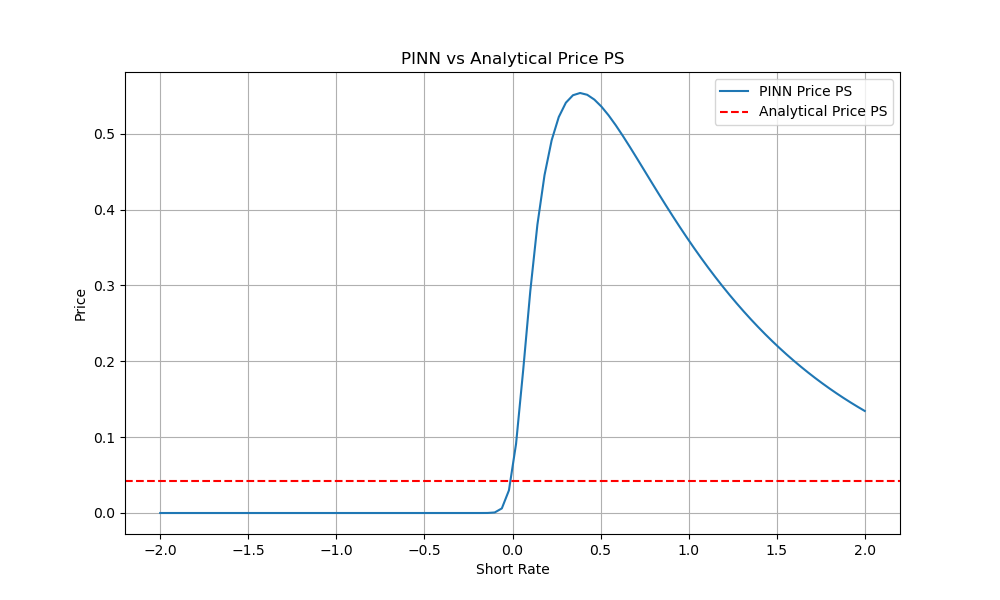

In [39]:
rates = np.linspace(-2.0, 2.0, 100)
TIMES_GRID = np.linspace(0.0, 10.0, 60)
prices = []
for r in rates:
    dfs = np.array([np.exp(-r * t) for t in TIMES_GRID])
    SPL = CubicSpline(TIMES_GRID, -np.log(dfs), bc_type='natural')
    prices.append(PS(0, T_EXP, PAY_DATES, FREQ, STRIKE, KAPPA, SIGMA, SPL))

prices = np.array(prices)
plt.figure(figsize=(10, 6))
plt.plot(rates, prices, label='PINN Price PS')
plt.axhline(price_ps, color='red', linestyle='--', label='Analytical Price PS')
plt.xlabel('Short Rate')
plt.ylabel('Price')
plt.title('PINN vs Analytical Price PS')
plt.legend()
plt.grid()
plt.show()

/var/folders/cp/l432p0ns1t38qmnyr_3l3r000000gn/T/ipykernel_10289/2985567780.py:12: RuntimeWarning:

divide by zero encountered in scalar divide



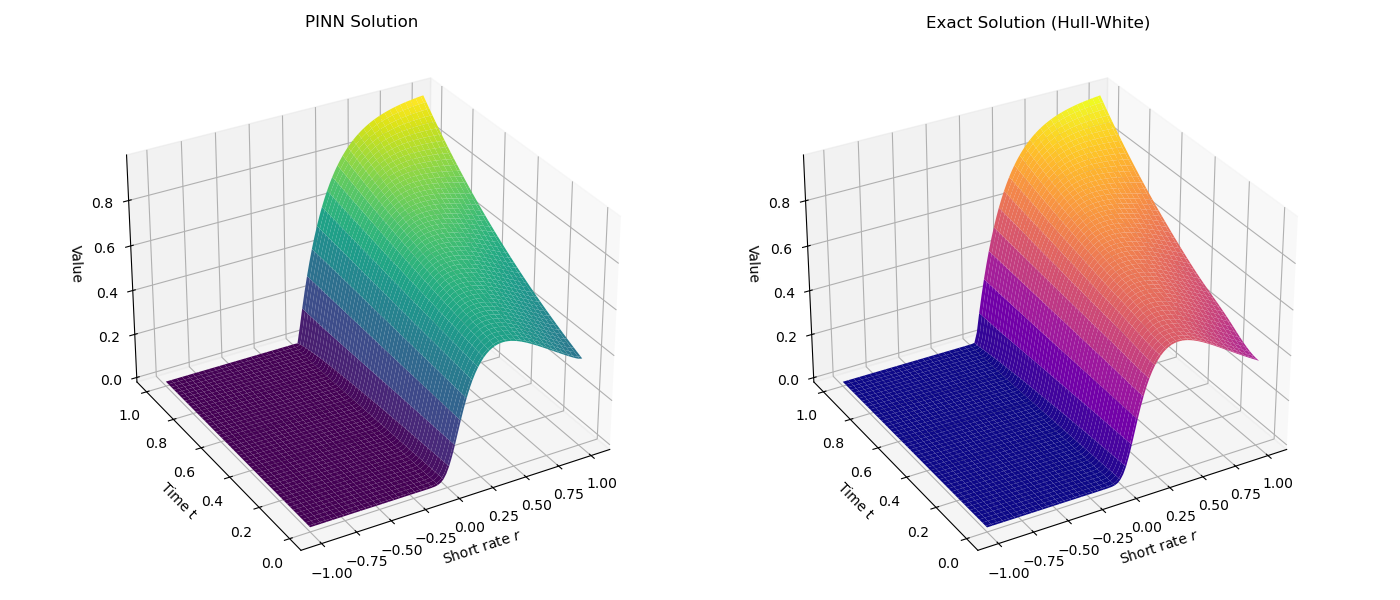

In [40]:
# %% [markdown]
# ### PINN surface vs analytic Hull-White (PS) + error map
# %%
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib import cm

# ─────────────────── 1) PINN surface on the (τ,r) grid ────────────────────
n_tau, n_r = 100, 100          # (use the same numbers you used to define Tau, R)
tau_vec = torch.linspace(0.0, 1.0, n_tau, dtype=DTYPE, device=DEV)
r_vec   = torch.linspace(R_MIN, R_MAX, n_r, dtype=DTYPE, device=DEV)
Tau, R  = torch.meshgrid(tau_vec, r_vec, indexing='ij')
coords  = torch.stack([Tau.reshape(-1), R.reshape(-1)], dim=1)

model.eval()
with torch.no_grad():
    price_grid = model(coords).reshape(n_tau, n_r).cpu().numpy()   # PINN €

# ─────────────────── 2) analytic Hull-White payer-swaption ────────────────
# Build a separate spline for *each* short-rate node so the analytic
# price varies with r. Here we assume the discount curve is flat at that r
# (same convention used earlier in your notebook).

tau_np = Tau.cpu().numpy() * T_EXP      # calendar time: τ·T_EXP
r_np   = R.cpu().numpy()                # short-rate values
exact  = np.empty_like(price_grid)

for j, r_val in enumerate(r_np[0, :]):                # loop over r-axis
    dfs_r = np.exp(-r_val * TIMES_GRID)               # flat curve @ r_val
    spl_r = CubicSpline(TIMES_GRID, -np.log(dfs_r), bc_type='clamped')

    for i, tau_val in enumerate(tau_np[:, 0]):        # loop over τ-axis
        t_now = (1.0 - tau_val / T_EXP) * T_EXP       # t = T - τ
        exact[i, j] = PS(t_now, T_EXP,
                         PAY_DATES, FREQ, STRIKE,
                         KAPPA, SIGMA, spl_r)

# ─────────────────── 3) absolute error on the grid ────────────────────────
err_abs = np.abs(price_grid - exact)

# meshes for plotting
R_plot   = r_np
Tau_plot = tau_np        # already in “years to expiry”

# ─────────────────── 4) FIGURE 1 – price surfaces ─────────────────────────-
fig1 = plt.figure(figsize=(14, 6))

# (a) PINN
ax1 = fig1.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(R_plot, 1-Tau_plot, price_grid,
                 cmap=cm.viridis, edgecolor='none')
ax1.set_title('PINN Solution')
ax1.set_xlabel('Short rate $r$')
ax1.set_ylabel('Time t')
ax1.set_zlabel('Value')
ax1.view_init(elev=30, azim=-120)

# (b) Analytic
ax2 = fig1.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(R_plot, 1-Tau_plot, exact,
                 cmap=cm.plasma, edgecolor='none')
ax2.set_title('Exact Solution (Hull-White)')
ax2.set_xlabel('Short rate $r$')
ax2.set_ylabel('Time t')
ax2.set_zlabel('Value')
ax2.view_init(elev=30, azim=-120)

fig1.tight_layout()
plt.show()


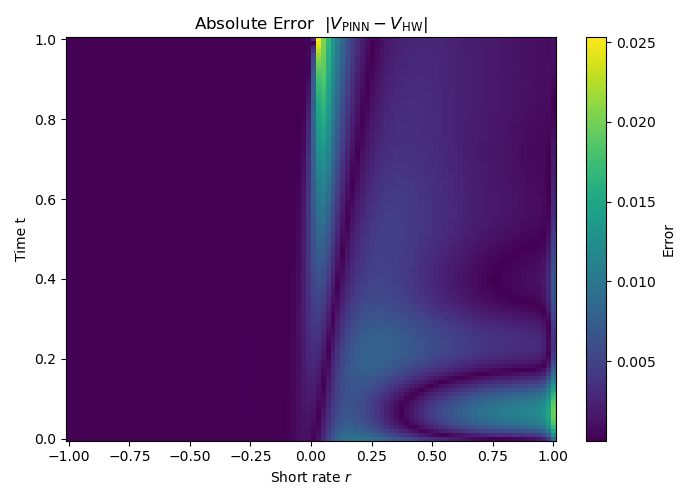

In [41]:
# ─────────────────── 5) FIGURE 2 – absolute-error heat-map ────────────────
fig2, ax = plt.subplots(figsize=(7, 5))
pcm = ax.pcolormesh(R_plot, 1-Tau_plot, err_abs,
                    shading='auto', cmap='viridis')
ax.set_title(r'Absolute Error  $|V_{\mathrm{PINN}}-V_{\mathrm{HW}}|$')
ax.set_xlabel('Short rate $r$')
ax.set_ylabel('Time t')
fig2.colorbar(pcm, ax=ax, label='Error')
fig2.tight_layout()
plt.show()

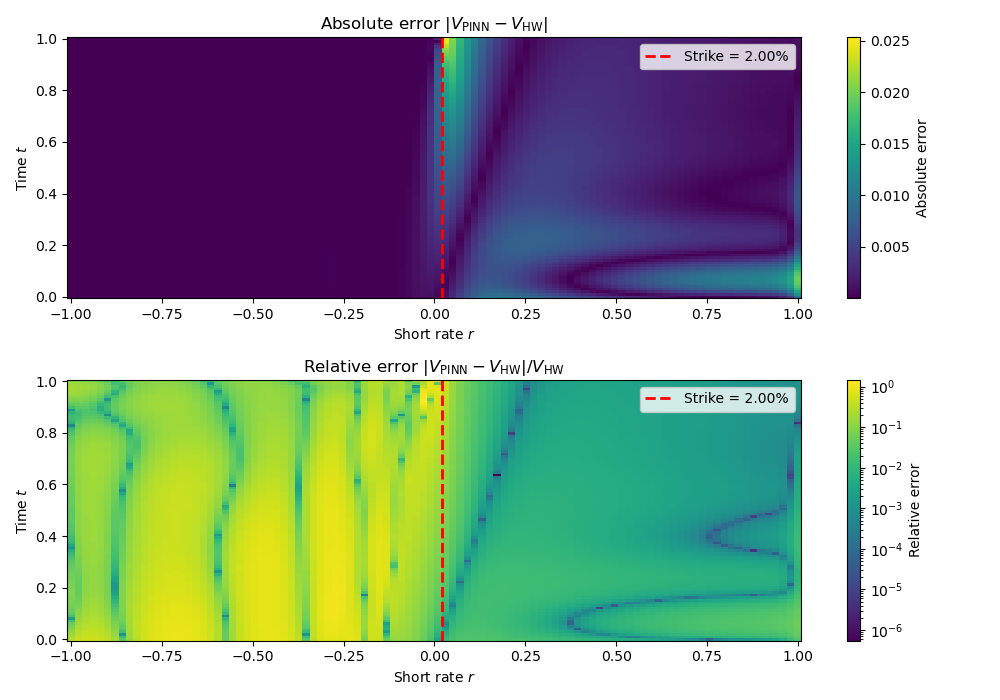

In [42]:
# %% [markdown]
# ### Absolute & relative error heat-maps (with strike line)
# %%
import matplotlib.colors as mcolors       # <- add if not yet imported

# ── 1)  Relative error matrix ─────────────────────────────────────────────
eps = 1e-4
denom   = np.maximum(np.abs(exact), eps)  # avoid division by zero
rel_err = np.abs(price_grid - exact) / denom    # fractional

# ── 2)  Two-panel figure ─────────────────────────────────────────────────
fig_err = plt.figure(figsize=(10, 7))

# (a) absolute error ------------------------------------------------------
ax_abs = fig_err.add_subplot(2, 1, 1)
pc1 = ax_abs.pcolormesh(R_plot, 1 - Tau_plot, err_abs,
                        shading='auto', cmap='viridis')
ax_abs.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2,
               label=f'Strike = {STRIKE:.2%}')
ax_abs.set_title(r'Absolute error $|V_{\mathrm{PINN}}-V_{\mathrm{HW}}|$')
ax_abs.set_xlabel('Short rate $r$')
ax_abs.set_ylabel('Time $t$')
fig_err.colorbar(pc1, ax=ax_abs, label='Absolute error')
ax_abs.legend()

# (b) relative error ------------------------------------------------------
ax_rel = fig_err.add_subplot(2, 1, 2)
valid   = rel_err[~np.isnan(rel_err) & (rel_err > 0)]
log_norm = mcolors.LogNorm(vmin=valid.min(), vmax=valid.max()) if valid.size else None

pc2 = ax_rel.pcolormesh(R_plot, 1 - Tau_plot, rel_err,
                        shading='auto', cmap='viridis', norm=log_norm)
ax_rel.axvline(x=STRIKE, color='red', linestyle='--', linewidth=2,
               label=f'Strike = {STRIKE:.2%}')
ax_rel.set_title(r'Relative error $|V_{\mathrm{PINN}}-V_{\mathrm{HW}}|/V_{\mathrm{HW}}$')
ax_rel.set_xlabel('Short rate $r$')
ax_rel.set_ylabel('Time $t$')
fig_err.colorbar(pc2, ax=ax_rel, label='Relative error')
ax_rel.legend()

plt.tight_layout()
plt.show()


In [43]:
np.linalg.norm(price_grid - exact, ord=2)/np.linalg.norm(exact, ord=2)  # L2 norm of relative error

np.float64(0.0057803903942707955)